<a href="https://colab.research.google.com/github/YoshiAligina/Allstate1B/blob/main/YoshiReductionTechniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
#XGBoost Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
#HyperParameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import uniform, randint
# Import these for random distribution
from sklearn.decomposition import PCA

In [6]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Allstate1B/claims_data.csv')
df.head()
df.columns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Index(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14', 'loss'],
      dtype='object', length=132)

In [7]:
label_column = "loss"
cat_feats= ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9']
cont_feats =  ['cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14']

In [8]:
feats = cont_feats + cat_feats

df_encoded = pd.get_dummies(df[cat_feats])
df_numeric = df[cont_feats]
df_combined = pd.concat([df_numeric, df_encoded], axis=1)

df_combined[label_column] = df[label_column]

correlation_matrix = df_combined.corr()


In [9]:
df.dtypes
df_numeric = df.select_dtypes(include=[np.number])
df_numeric
corrMatrix = df_numeric.corr()
corrMatrix

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
id,1.000000,0.002130,0.000783,0.000816,0.002578,0.000775,0.001426,0.002209,0.005534,0.001870,0.002582,0.001075,0.000889,0.000442,-0.004924,-0.001122
cont1,0.002130,1.000000,-0.085180,-0.445431,0.367549,-0.025230,0.758315,0.367384,0.361163,0.929912,0.808551,0.596090,0.614225,0.534850,0.056688,-0.010237
cont2,0.000783,-0.085180,1.000000,0.455861,0.038693,0.191427,0.015864,0.048187,0.137468,-0.032729,0.063526,0.116824,0.106250,0.023335,-0.045584,0.141528
cont3,0.000816,-0.445431,0.455861,1.000000,-0.341633,0.089417,-0.349278,0.097516,-0.185432,-0.417054,-0.325562,0.025271,0.006111,-0.418203,-0.039592,0.111053
cont4,0.002578,0.367549,0.038693,-0.341633,1.000000,0.163748,0.220932,-0.115064,0.528740,0.328961,0.283294,0.120927,0.130453,0.179342,0.017445,-0.035831
cont5,0.000775,-0.025230,0.191427,0.089417,0.163748,1.000000,-0.149810,-0.249344,0.009015,-0.088202,-0.064967,-0.151548,-0.148217,-0.082915,-0.021638,-0.011355
cont6,0.001426,0.758315,0.015864,-0.349278,0.220932,-0.149810,1.000000,0.658918,0.437437,0.797544,0.883351,0.773745,0.785144,0.815091,0.042178,0.040967
cont7,0.002209,0.367384,0.048187,0.097516,-0.115064,-0.249344,0.658918,1.000000,0.142042,0.384343,0.492621,0.747108,0.742712,0.288395,0.022286,0.119799
cont8,0.005534,0.361163,0.137468,-0.185432,0.528740,0.009015,0.437437,0.142042,1.000000,0.452658,0.336588,0.302381,0.315904,0.476402,0.043539,0.030508
cont9,0.001870,0.929912,-0.032729,-0.417054,0.328961,-0.088202,0.797544,0.384343,0.452658,1.000000,0.785697,0.608000,0.626656,0.642028,0.074154,0.014456


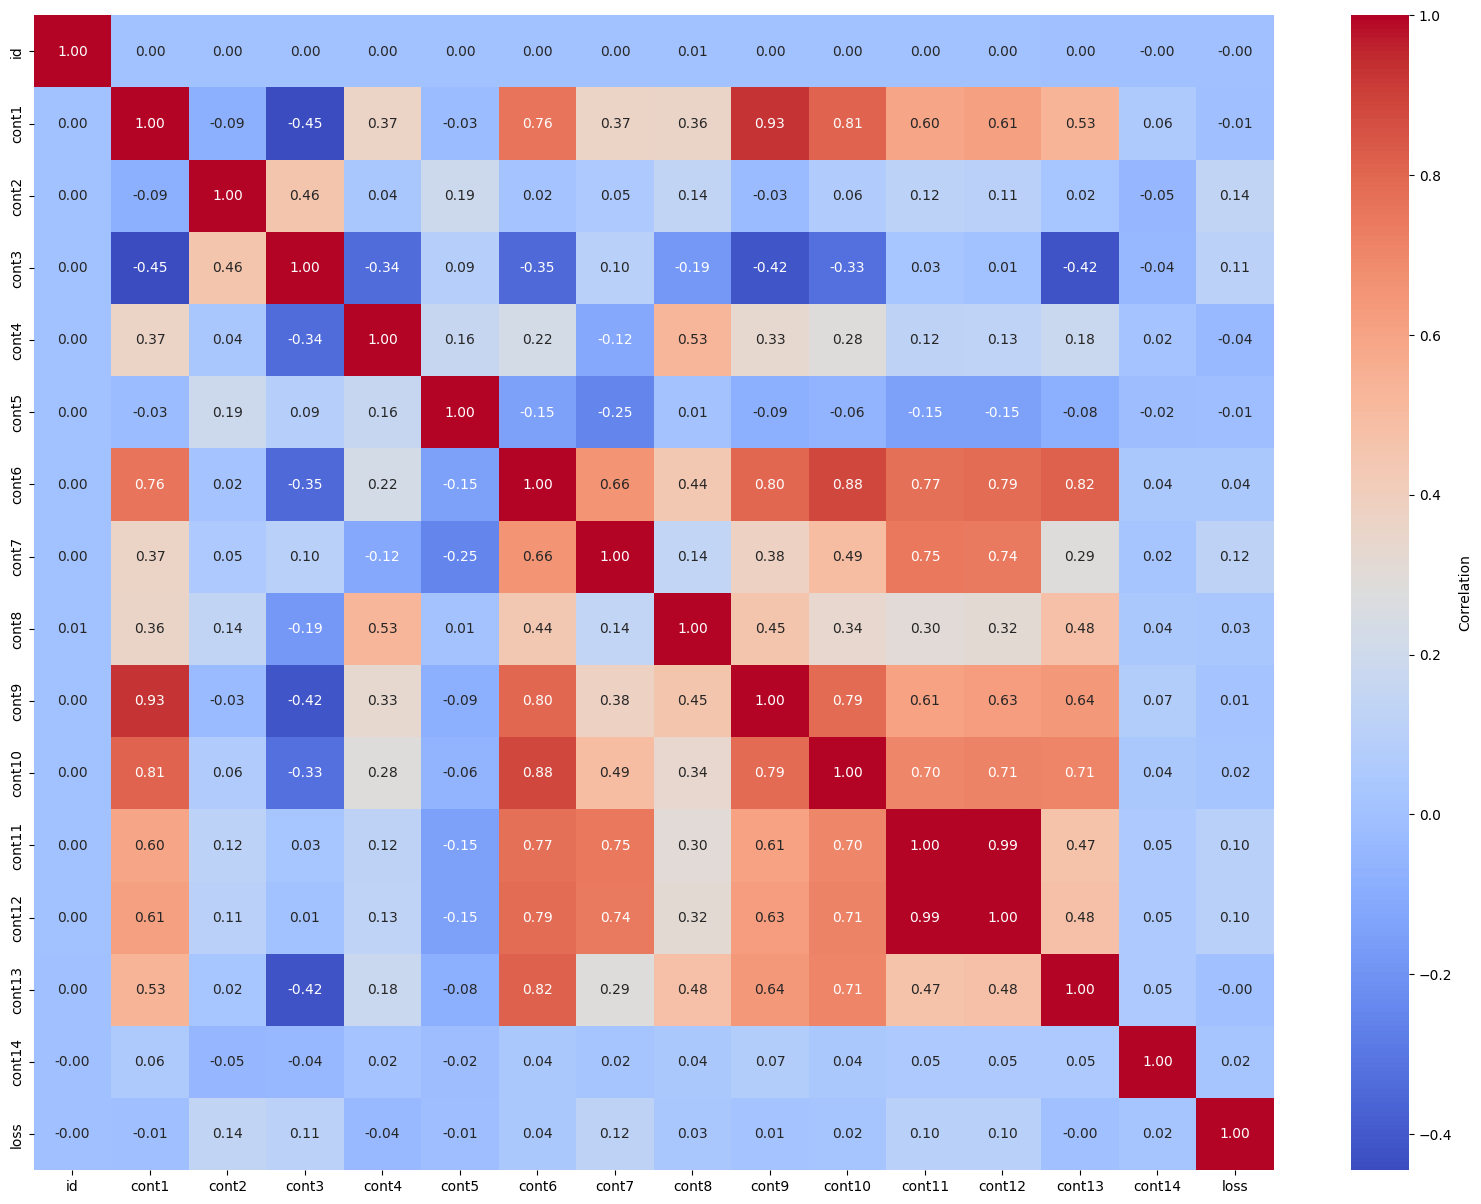

In [10]:
plt.figure(figsize=(20, 15))  # Width x Height in inches
sns.heatmap(corrMatrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 10}, cbar_kws={'label': 'Correlation'})
plt.show()

In [ ]:
# Assuming df is your DataFrame
# List of categorical columns based on your data dictionary
categorical_columns = [f'cat{i}' for i in range(1, 117)]  # cat1 to cat116

# Initialize a list to store results
chi2_results = []

# Loop through each pair of categorical columns
for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        col1 = categorical_columns[i]
        col2 = categorical_columns[j]

        # Create a contingency table
        contingency_table = pd.crosstab(df[col1], df[col2])

        # Perform Chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Store the results
        chi2_results.append({
            'Column 1': col1,
            'Column 2': col2,
            'Chi2': chi2,
            'P-value': p,
            'Degrees of Freedom': dof,
            'Expected Frequencies': expected
        })

# Convert results to a DataFrame for easier analysis
chi2_results_df = pd.DataFrame(chi2_results)

# Filter results for significant associations (0.05 value)
significant_results = chi2_results_df[chi2_results_df['P-value'] < 0.05]

# Display the significant results
print(significant_results)

In [ ]:
# XGBoost Model building using Label Encoding Strategy

# # Assuming 'loss' is the target and categorical columns range from 'cat1' to 'cat116'
categorical_columns = [f'cat{i}' for i in range(1, 117)]
continuous_columns = [f'cont{i}' for i in range(1, 15)]
target_column = 'loss'

# Initialize LabelEncoder for categorical columns
le = LabelEncoder()

# Encode all categorical columns using LabelEncoder
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Select features (X) and target (y)
X = df[categorical_columns + continuous_columns]
y = df[target_column]

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor with parameters in a dictionary
params = {
    'n_estimators': 125,
    'learning_rate': 0.05,
    'eval_metric': 'rmse',  # Use evaluation metric like RMSE
}

# Initialize XGBoost Regressor with the params dictionary
model = xgb.XGBRegressor(**params)

# Train the model without early stopping argument directly
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the variance of the target variable in the test set
variance = y_test.var()

# Normalize the MSE by dividing it by the variance of the target variable
normalized_mse = mse / variance

print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {normalized_mse}")

In [ ]:
# Assuming 'loss' is the target and categorical columns range from 'cat1' to 'cat116'
categorical_columns = [f'cat{i}' for i in range(1, 117)]
continuous_columns = [f'cont{i}' for i in range(1, 15)]
target_column = 'loss'

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(df[categorical_columns])

# Combine the continuous columns and the one-hot encoded categorical columns
X = pd.concat([pd.DataFrame(encoded_categorical), df[continuous_columns]], axis=1)
y = df[target_column]

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor with parameters in a dictionary
params = {
    'n_estimators': 125,
    'learning_rate': 0.05,
    'eval_metric': 'rmse',
}

# Initialize XGBoost Regressor with the params dictionary
model = xgb.XGBRegressor(**params)

# Train the model without early stopping argument directly
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the variance of the target variable in the test set
variance = y_test.var()

# Normalize the MSE by dividing it by the variance of the target variable
normalized_mse = mse / variance

print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {normalized_mse}")

In [ ]:
params_grid = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=params_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

In [ ]:
# Perform K-Fold Cross-Validation with 5 folds
cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)

print(f"Cross-Validated MSE: {-cv_scores.mean()}")

In [ ]:
# Assuming 'loss' is the target and categorical columns range from 'cat1' to 'cat116'
categorical_columns = [f'cat{i}' for i in range(1, 117)]
continuous_columns = [f'cont{i}' for i in range(1, 15)]
target_column = 'loss'

# Perform One-Hot Encoding on the categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(df[categorical_columns])

# Combine the continuous columns and the one-hot encoded categorical columns
X = pd.concat([pd.DataFrame(encoded_categorical), df[continuous_columns]], axis=1)
y = df[target_column]

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
model = xgb.XGBRegressor()

# Define the parameter grid for Randomized Search
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.5, 1.0),
    'colsample_bytree': uniform(0.5, 1.0)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,  # Number of different combinations to try
    scoring='neg_mean_squared_error',
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to find the best model
random_search.fit(X_train, y_train)

# Get the best parameters from the search
print(f"Best Parameters: {random_search.best_params_}")

# Make predictions using the best estimator
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the variance of the target variable in the test set
variance = y_test.var()

# Normalize the MSE by dividing it by the variance of the target variable
normalized_mse = mse / variance

print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {normalized_mse}")

In [ ]:
# Find the minimum and maximum values of the 'loss' column
min_loss = df['loss'].min()
max_loss = df['loss'].max()

# Calculate the range (max - min)
loss_range = max_loss - min_loss

print(f"Minimum loss: {min_loss}")
print(f"Maximum loss: {max_loss}")
print(f"Range of loss: {loss_range}")

Previous Content ^^^ From Bode, Yoshi Reduction Below

In [ ]:
# Calculate the correlation between features and the target variable 'loss'
correlation_with_loss = df_combined.corr()['loss'].abs().sort_values(ascending=False)

# Select the top N features with the highest correlation (e.g., top 10)
num_features_to_select = 10 #Set threshold values within a certain range.
selected_features = correlation_with_loss[1:num_features_to_select + 1].index.tolist()  # Exclude 'loss'

df_selected = df_combined[selected_features + ['loss']]
print(f"Selected Features: {selected_features}")
X = df_selected.drop('loss', axis=1)
y = df_selected['loss']

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Calculate the variance of the target variable in the test set
variance = y_test.var()
normalized_mse = mse / variance

print(f"Mean Squared Error: {mse}")
print(f"Normalized Mean Squared Error: {normalized_mse}")


In [ ]:
# Separate features (X) and target (y)
X = df_combined.drop('loss', axis=1)
y = df_combined['loss']

# Initialize PCA with the desired number of components
pca = PCA(n_components=0.95)  # Keep components that explain 95% of variance

# Fit and transform the data
X_pca = pca.fit_transform(X)

# Create a new DataFrame with the reduced features
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i}' for i in range(X_pca.shape[1])])
df_pca['loss'] = y


X_train, X_test, y_train, y_test = train_test_split(df_pca.drop('loss', axis=1), df_pca['loss'], test_size=0.2, random_state=42)
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error with PCA: {mse}")

